## **Data Analysis of Titanic Dataset**

### Define the objective:
*The goal of this data analysis is to find relevance and patterns of the dataset, using statistical method and data visualization to show a clear relationship between different features within the dataset.*

In [1]:
#### import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# import KNN from scikit-learn library (especially for ML)
from sklearn.neighbors import KNeighborsClassifier
# import logistic regression model
from sklearn.linear_model import LogisticRegression
# import random forest model
from sklearn.ensemble import RandomForestClassifier
# import data split method 
from sklearn.model_selection import train_test_split
# import K-fold cross-validation method
from sklearn.model_selection import GridSearchCV
# import evaluation method
from sklearn.metrics import accuracy_score, classification_report
# normalize the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# import PyTorch for Deep Learning
import torch
# import neural network
from torch import nn
# import relative math functions
import torch.nn.functional as F
# import PyTorch DataLoader
from torch.utils.data import Dataset, DataLoader

### Data Collection:
*Collect the relevant data from competition website, then convert it into pandas DataFrame.*

In [2]:
#### load the data
DIR_PATH = '/kaggle/input/titanic'
# load the train data, which is split into train and test (validation) afterwards
train = pd.read_csv(os.path.join(DIR_PATH, 'train.csv'))
# the true test data, which is used to provide an unbiased evaluation of a final model fit
test = pd.read_csv(os.path.join(DIR_PATH, 'test.csv'))

### Data Clearning:
*Clean the unhelpful columns, NaN value, duplicates and inconsistencies.*

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Note: 'Age', 'Cabin' and 'Embarked' columns have missing values.

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# define a function that categorizes fare
def categorize_fare(fare):
    if fare <= 10:
        return 0
    elif fare <= 50:
        return 1
    elif fare <= 100:
        return 2
    else:
        return 3

# define a function that categorizes age
def categorize_age(age):
    if age < 13:  
        return 0
    elif age < 20:  
        return 1
    elif age < 60:  
        return 2
    else:  
        return 3

def data_cleaning(df):
    # impute missing ages with the median
    df['Age'] = df['Age'].fillna(df['Age'].median())
    # impute missing ages with the mean
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    # impute missing 'Embarked' values with the mode
    most_common_embarked = df['Embarked'].mode()[0]
    df['Embarked'] = df['Embarked'].fillna(most_common_embarked)
    
    # feature engineering
    # create a new feature fare category
    df['Fare_Category'] = df['Fare'].apply(categorize_fare)
    df['Age_Category'] = df['Age'].apply(categorize_age)
    # convert categorical data into numerical data
    # use get_dummies() to perform one-hot encoding on 'Sex' and 'Embarked'
    df = pd.get_dummies(df, columns=['Pclass', 'Sex', 'Embarked', 'Fare_Category', 'Age_Category'], dtype=int)
    # drop unhelpful feature from the observation
    df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    
    return df

In [6]:
train = data_cleaning(train)

In [7]:
# revisit the cleaned dataset
train.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Embarked_Q,Embarked_S,Fare_Category_0,Fare_Category_1,Fare_Category_2,Fare_Category_3,Age_Category_0,Age_Category_1,Age_Category_2,Age_Category_3
0,0,22.0,1,0,7.2500,0,0,1,0,1,...,0,1,1,0,0,0,0,0,1,0
1,1,38.0,1,0,71.2833,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,...,0,1,1,0,0,0,0,0,1,0
3,1,35.0,1,0,53.1000,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,...,0,1,1,0,0,0,0,0,1,0


### Data Preprocessing:

#### Feature Engineering:
*Create new features from existing ones to improve model performance.*

In [8]:
#### feature engineering is added to data_clean() function for convenience
# convert categorical data into numerical data
# use get_dummies() to perform one-hot encoding on 'Sex' and 'Embarked'
# df = pd.get_dummies(df, columns=['Pclass', 'Sex', 'Embarked'], dtype=int)

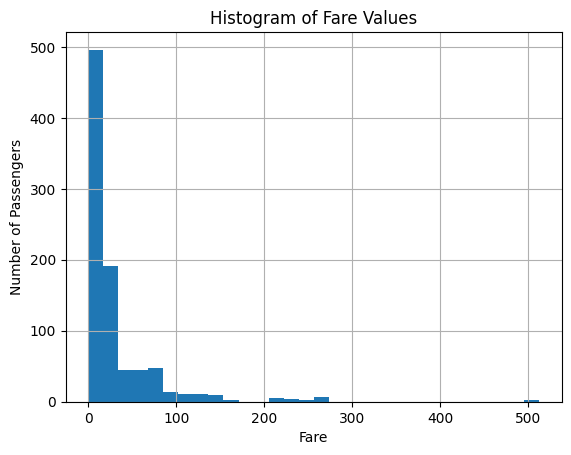

In [9]:
# plotting the histogram of the 'Fare' column
train['Fare'].hist(bins=30)

# adding titles and labels
plt.title('Histogram of Fare Values')
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.grid(True)
# display the plot
plt.show()

In [10]:
# define a function that categorizes fare
def categorize_fare(fare):
    if fare <= 50:
        return 0
    elif fare <= 100:
        return 1
    elif fare <= 150:
        return 2
    else:
        return 3

# apply the function to the 'Fare' column to create a new 'Fare_Category' column
# df['Fare_Category'] = df['Fare'].apply(categorize_fare)

#### Data Transformation:
*Normalize, scale, or encode data as necessary.*

In [11]:
# separate the feature matrix and the target value
X = train.drop('Survived', axis=1)
y = train['Survived']

# normalize the data
# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scaling data helps to bring all the features to a uniform scale
# initialize the scaler
scaler = StandardScaler()
# fit on training set only
scaler.fit(X_train)
# apply transform to both the training set and the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Data Modeling

> > ### K-Nearest Neighbors: 
> > This is a type of instance-based supervised learning algorithm used for both classification and regression.  
> 
> Pros:
> 1. simple to understand and implement.
> 2. no need to build a model, tune several parameters.
> 3. the algorithm is versatile, it can be used for classification, regression and search (as in recommender system).
> 
> Cons:
> 1. the algorithm gets significantly slower as the dataset grows.
> 2. requires high memory - needs to store all the training data.
> 3. sensitive to the scale of the data and irrelevant features.
> 4. typically not as accurate as more sophisticated methods, especially on datasets with a lot of features.

In [12]:
def save_model_predictions_to_csv(model, test_dataset, scaler, output_filename='submission.csv'):
    
    try:
        # save the 'PassengerId' column
        PassengerId = test_dataset['PassengerId']
        # clean the dataset
        test_dataset = data_cleaning(test_dataset)
        test_dataset = scaler.transform(test_dataset)
        # make predictions using the provided model
        y_pred = model.predict(test_dataset)

        # create a DataFrame with 'PassengerId' and the predictions
        submission_df = pd.DataFrame({
            'PassengerId': PassengerId,
            'Survived': y_pred
        })

        # save the DataFrame to a CSV file
        submission_df.to_csv(output_filename, index=False)
        print(f"Your submission was successfully saved to {output_filename}!")
        
    except Exception as e:
        # handle any exceptions that might occur
        print("An error occurred while saving the submission:")
        print(e)

In [13]:
def train_and_evaluate_knn(X_train, y_train, X_test, y_test, n_neighbors=3):
    '''Train a K-Nearest Neighbors classifier and evaluate its accuracy.'''
    
    # initialize the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    # fit the model on the training data
    knn.fit(X_train, y_train)
    # predict the labels for the test set
    y_pred = knn.predict(X_test)
    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy: .2f}')
    
    return knn

In [14]:
# test it when K is 3
knn = train_and_evaluate_knn(X_train, y_train, X_test, y_test, n_neighbors=3)
# save_model_predictions_to_csv(knn, test)

Accuracy:  0.80


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         891 non-null    int64  
 1   Age              891 non-null    float64
 2   SibSp            891 non-null    int64  
 3   Parch            891 non-null    int64  
 4   Fare             891 non-null    float64
 5   Pclass_1         891 non-null    int64  
 6   Pclass_2         891 non-null    int64  
 7   Pclass_3         891 non-null    int64  
 8   Sex_female       891 non-null    int64  
 9   Sex_male         891 non-null    int64  
 10  Embarked_C       891 non-null    int64  
 11  Embarked_Q       891 non-null    int64  
 12  Embarked_S       891 non-null    int64  
 13  Fare_Category_0  891 non-null    int64  
 14  Fare_Category_1  891 non-null    int64  
 15  Fare_Category_2  891 non-null    int64  
 16  Fare_Category_3  891 non-null    int64  
 17  Age_Category_0  

In [16]:
#### implement K-fold cross-validation to choose the optimal K
knn = KNeighborsClassifier()
# define the parameter grid
param_grid = {'n_neighbors': range(1, 31)}
# use GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5) # cv is the number of folds
# fit the grid search to the data
grid_search.fit(X_train, y_train)
# get the best parameter
best_k = grid_search.best_params_['n_neighbors']
print(f"The best value for 'k' is {best_k}")

The best value for 'k' is 16


In [17]:
# test it when K is 4
train_and_evaluate_knn(X_train, y_train, X_test, y_test, n_neighbors=4)

Accuracy:  0.79


KNeighborsClassifier(n_neighbors=4)

> > ### Logistic regression: 
> > This is a statistical model that can model a binomial outcome with one or more explanatory variables. It is used extensively in many fields, including the medical and social sciences.  
> 
> Pros:
> 1. it can perform well when the dataset is linearly separable or when the boundary between classes can be approximated with a linear combination of features.
> 2. logistic regression not only provides a classification but also gives the probabilities of the outcome, which can be a valuable insight.
> 3. can be extended to multiclass classification problems.
> 4. it is computationally less intensive.
> 
> Cons:
> 1. it assumes a linear relationship between the independent variables and log odds of the dependent variables.
> 2. logistic regression can't capture complex relationships with non-linear boundaries as accurately as neural networks and decision trees.
> 3. it is sensitive to outliers and may need scale the data.

In [18]:
def train_and_evaluate_logreg(X_train, y_train, X_test, y_test):
    '''Train a logistic regression classifier and evaluate its accuracy.'''
    
    # initialize the logistic model
    logreg = LogisticRegression()
    # fit the model to the training data
    logreg.fit(X_train, y_train)
    # predict probabilities
    y_pred = logreg.predict(X_test)
    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    # evaluate accuracy
    print('#' * 50)
    print(f"Accuracy:\n {accuracy: .2f}")

    # evaluate classification report
    print('#' * 50)
    print(f"classification report:\n {classification_report(y_test, y_pred)}")
    
    # access the model's coefficients and intercept
    coefficients = logreg.coef_
    intercept = logreg.intercept_
    # matching the coefficients to the feature names
    feature_importance = pd.DataFrame(data=coefficients.T, index=X.columns, columns=['Coefficient'])
    print('#' * 50)
    print(f"feature importance:\n {feature_importance}")
    
    return logreg

In [19]:
logreg = train_and_evaluate_logreg(X_train, y_train, X_test, y_test)
# save_model_predictions_to_csv(logreg, test, scaler)

##################################################
Accuracy:
  0.81
##################################################
classification report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       157
           1       0.79      0.73      0.76       111

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.81      0.81      0.80       268

##################################################
feature importance:
                  Coefficient
Age                -0.207214
SibSp              -0.602374
Parch              -0.214519
Fare                0.269437
Pclass_1            0.169273
Pclass_2            0.220714
Pclass_3           -0.324084
Sex_female          0.661324
Sex_male           -0.661324
Embarked_C          0.135689
Embarked_Q          0.051466
Embarked_S         -0.150344
Fare_Category_0    -0.130753
Fare_Category_1    -0.067104
Fare_Category_2     0.3

> > ### Random Forest: 
> > This is an ensemble machine learning algorithm that combines multiple decision trees to create a more accurate and robust model. It's particularly well-suited for classification and regression tasks and works well with both categorical and continuous data.
> 
> Pros: 
> 1. it can be used for both classification and regression tasks and has the ability to handle large datasets with higher dimensionality.
> 2. it can capture nonlinearity in the data by combining the results from various trees.
> 3. due to the averaging of multiple trees, it is quite robust to noisein the input data.
> 
> Cons:
> 1. Random Forest models are not easily interpretable.
> 2. it can be computationly intensive and slow to train.
> 3. it's not ideal for linear problems.

In [20]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test):
    '''Train a random forest classifier and evaluate its accuracy.'''
    
    # initialize the Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    # fit the model to the training data
    rf.fit(X_train, y_train)
    # predict class
    y_pred = rf.predict(X_test)

    # evaluate accuracy
    print(f"Accuracy:\n {accuracy_score(y_test, y_pred)}")
    # detailed classification report
    print(f"classification report:\n {classification_report(y_test, y_pred)}")
    
    return rf

In [21]:
rf = train_and_evaluate_rf(X_train, y_train, X_test, y_test)
# save_model_predictions_to_csv(rf, test)

Accuracy:
 0.7985074626865671
classification report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83       157
           1       0.77      0.73      0.75       111

    accuracy                           0.80       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



> > ### Deep Learning:
> > 
> > Deep learning is a subset of machine learning that utilizes artificial neural networks with multiple layers—hence the term "deep"—to model and understand complex patterns in data. It is known for its effectiveness in tasks that deal with unstructured data like images, text, and audio.
> 
> Pros:
> 1. Flexibility in handling unstructured data:** Deep learning models excel at processing data with high dimensionality and complexity, such as images, sound waves, and text.
> 2. High accuracy: They can achieve high levels of accuracy in various applications, including image recognition, natural language processing, and speech recognition, given enough data.
> 3. Automatic feature extraction: These models can automatically learn the representations needed for feature detection or classification, eliminating the need for manual feature engineering.
> 
> Cons:
> 1. Large data requirement: Deep learning models typically require vast amounts of labeled data to train effectively.
> 2. Computational intensity: The training process for deep learning models is resource-intensive, often necessitating the use of GPUs or even distributed computing environments.
> 3. Opacity: Often considered as "black boxes," deep learning models can be challenging to interpret, making it hard to understand the exact reasons behind their decisions or predictions.

In [22]:
#### create a custom dataset class that inherits torch.utils.data.Dataset
# create TabularDataset class in order to use DataLoader
class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

# create PyTorch Dataset objects
train_dataset = TabularDataset(X_train, y_train)
test_dataset = TabularDataset(X_test, y_test)

# create DataLoaders
# in each epoch, the train process iterate each bach until all samples are calculated
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# create an iterator over the dataset
train_iter = iter(train_loader)
# get the next batch
features, labels = next(train_iter)
# print the shapes
print(f'Feature batch shape: {features.size()}')
print(f'Labels batch shape: {labels.size()}')

Feature batch shape: torch.Size([64, 20])
Labels batch shape: torch.Size([64])


In [23]:
#### define the model
class ClassificationModel(nn.Module):
    def __init__(self, num_features, num_classes=1):  # default num_classes to 1 for binary classification
        super().__init__()
        self.sequential1 = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU()
        )
        self.sequential2 = nn.Sequential(
            nn.Linear(64, 48),
            nn.ReLU()
        )
        self.sequential3 = nn.Sequential(
            nn.Linear(48, 32),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(32, num_classes) 

    def forward(self, x):
        x = self.sequential1(x)
        x = self.sequential2(x)
        x = self.sequential3(x)
        x = torch.sigmoid(self.output_layer(x))  # using sigmoid for binary classification
        return x

In [24]:
#### define the model 2
class ClassificationModel_2(nn.Module):
    def __init__(self, num_features, num_classes=1, dropout_rate=0.5):
        super().__init__()
        self.layer1 = nn.Linear(num_features, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(64, 48)
        self.batch_norm2 = nn.BatchNorm1d(48)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(48, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.output_layer = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x = F.relu(self.batch_norm1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.batch_norm2(self.layer2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.batch_norm3(self.layer3(x)))
        x = self.dropout3(x)
        
        x = torch.sigmoid(self.output_layer(x))  # still using sigmoid for binary classification
        return x

In [25]:
# create an instance of the ClassificationModel with the number of features from training data
model = ClassificationModel_2(num_features=X_train.shape[1])

# use BCEWithLogitsLoss which combines a sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss()
# initialize the optimizer with the Adam algorithm and a learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# set the device to cuda if available, otherwise use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# transfer the model to the chosen device
model.to(device)

# set the number of epochs for training
num_epochs = 1500

# start the training loop
for epoch in range(num_epochs):
    # set the model to training mode
    model.train()
    # initialize the total loss variable
    total_loss = 0

    # iterate over batches of data from the train_loader
    for inputs, labels in train_loader:
        # transfer inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)
        # reset the gradients of the model parameters
        optimizer.zero_grad()
        # forward pass: compute the model outputs
        outputs = model(inputs)
        # calculate the loss between outputs and labels
        loss = criterion(outputs, labels.unsqueeze(1))
        # backward pass: compute the gradient of the loss with respect to model parameters
        loss.backward()
        # add the current loss to the total loss
        total_loss += loss.item()
        # update the model parameters
        optimizer.step()
    
    # print the loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

# switch off gradients for validation, saves memory and computations
with torch.no_grad():
    # set the model to evaluation mode
    model.eval()
    # initialize correct prediction count
    correct = 0
    # initialize total prediction count
    total = 0

    # iterate over batches of data from the test_loader
    for inputs, labels in test_loader:
        # transfer inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)
        # forward pass: compute the model outputs
        outputs = model(inputs)
        # convert outputs probabilities to predicted class (0 or 1)
        predicted = outputs.round()
        # count the total number of labels
        total += labels.size(0)
        # count the number of correct predictions
        correct += (predicted == labels.unsqueeze(1)).sum().item()

# calculate the accuracy of predictions
accuracy = (correct / total) * 100
# print the accuracy of the model on the test data
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')

Epoch 1/1500, Loss: 0.7791934192180634
Epoch 101/1500, Loss: 0.6187424480915069
Epoch 201/1500, Loss: 0.6156799912452697
Epoch 301/1500, Loss: 0.6158924221992492
Epoch 401/1500, Loss: 0.6168446063995361
Epoch 501/1500, Loss: 0.6117277443408966
Epoch 601/1500, Loss: 0.6105581998825074
Epoch 701/1500, Loss: 0.6119938492774963
Epoch 801/1500, Loss: 0.6130316197872162
Epoch 901/1500, Loss: 0.6092469573020936
Epoch 1001/1500, Loss: 0.6091087996959687
Epoch 1101/1500, Loss: 0.6116854250431061
Epoch 1201/1500, Loss: 0.6095544874668122
Epoch 1301/1500, Loss: 0.6079521656036377
Epoch 1401/1500, Loss: 0.6097125351428986
Accuracy of the model on the test data: 82.46%


In [26]:
def save_model_predictions_to_csv(model, test_dataset, scaler, output_filename='submission.csv'):
    
    try:
        # save the 'PassengerId' column
        PassengerId = test_dataset['PassengerId']
        # clean the dataset
        test_dataset = data_cleaning(test_dataset)
        test_dataset = scaler.transform(test_dataset)
        # make predictions using the provided model
        y_pred = model(torch.tensor(test_dataset, dtype=torch.float32).to(device))
        # create a DataFrame with 'PassengerId' and the predictions
        submission_df = pd.DataFrame({
            'PassengerId': PassengerId,
            'Survived': y_pred
        })

        # save the DataFrame to a CSV file
        submission_df.to_csv(output_filename, index=False)
        print(f"Your submission was successfully saved to {output_filename}!")
        
    except Exception as e:
        # handle any exceptions that might occur
        print("An error occurred while saving the submission:")
        print(e)

In [27]:
save_model_predictions_to_csv(model, test, scaler)

An error occurred while saving the submission:
can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
